In [18]:
# necessary imports
import helper.training_preprocess as tp
import helper.eval_worker as ew
import models.ekf as ekf_support
from models.ekf import EKF

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [19]:
%%time
train_df, test_df, train_traj_data, test_traj_data = tp.readin_dataframes(train_split=0.9, sensor_pos_uncer=5)

Number of Train Trajectories: 4584
Number of Test Trajectories: 509
CPU times: total: 2min 3s
Wall time: 2min 49s


In [20]:
display(train_df)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,-20.110498,2.792424,17.071516,0.827515,-0.114170,0.334543,-22.181779,-2.561623,18.522774,0.833350,-0.117166,0.330691,5,0.005,-18.733405,0.042307,15.954745,0.100000
1,0.100000,-20.027747,2.781007,17.104970,0.687851,-0.017778,0.435271,-18.733405,0.042307,15.954745,0.688128,-0.023040,0.430779,5,0.005,-20.471752,7.155106,15.476073,0.100000
2,0.200000,-19.958962,2.779229,17.148497,0.606798,0.254735,0.726220,-20.471752,7.155106,15.476073,0.603002,0.260034,0.726577,5,0.005,-14.953621,0.792920,15.215707,0.100000
3,0.300000,-19.898282,2.804703,17.221119,0.404264,0.639850,0.534433,-14.953621,0.792920,15.215707,0.407858,0.633312,0.542991,5,0.005,-21.889209,8.467597,19.445671,0.100000
4,0.400000,-19.857856,2.868688,17.274563,0.153350,1.112576,0.332398,-21.889209,8.467597,19.445671,0.163390,1.106496,0.337948,5,0.005,-25.509540,0.240684,25.198624,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691333,9.599991,8.337065,-20.357918,17.558845,-2.411027,1.010997,-1.751179,9.606162,-20.687312,19.961326,-2.402532,1.009820,-1.746491,5,0.005,21.057834,-11.795069,8.566714,0.100000
691334,9.699991,8.095962,-20.256818,17.383726,-1.895313,0.976631,-1.514117,21.057834,-11.795069,8.566714,-1.891728,0.979041,-1.514401,5,0.005,4.960543,-31.419733,11.872031,0.099999
691335,9.799991,7.906432,-20.159155,17.232316,-1.740731,1.113609,-1.719310,4.960543,-31.419733,11.872031,-1.744448,1.109826,-1.723192,5,0.005,5.732348,-21.045876,8.918855,0.099999
691336,9.899990,7.732359,-20.047795,17.060386,-1.374057,1.130091,-1.572190,5.732348,-21.045876,8.918855,-1.375354,1.131162,-1.574275,5,0.005,9.800757,-17.894225,25.217450,0.100000


In [21]:
display(test_df)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,-40.805557,-7.557310,16.847527,-3.592263,0.964076,0.089414,-41.023734,-0.475375,12.981480,-3.600823,0.959860,0.089190,5,0.005,-41.770667,-10.934820,22.791739,0.100000
1,0.100000,-41.164783,-7.460903,16.856468,-2.761677,0.770851,0.190097,-41.770667,-10.934820,22.791739,-2.758827,0.773582,0.200685,5,0.005,-35.033618,-15.413176,12.096581,0.100000
2,0.200000,-41.440951,-7.383818,16.875478,-2.402171,0.680947,0.580820,-35.033618,-15.413176,12.096581,-2.408755,0.679070,0.577381,5,0.005,-41.779384,-5.627968,15.343175,0.100000
3,0.300000,-41.681167,-7.315723,16.933560,-1.839856,0.252255,1.005508,-41.779384,-5.627968,15.343175,-1.841395,0.256130,1.004015,5,0.005,-43.290321,-1.181315,15.504357,0.100000
4,0.399999,-41.865152,-7.290498,17.034110,-1.630406,-0.376203,1.386813,-43.290321,-1.181315,15.504357,-1.628211,-0.373237,1.389324,5,0.005,-42.800511,-7.366224,17.846503,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74797,11.399989,-31.410724,-2.445097,5.099618,-2.817649,-2.408035,-0.115101,-32.751353,0.539629,-0.623517,-2.817362,-2.399967,-0.117617,5,0.005,-30.363012,0.250172,7.577426,0.099999
74798,11.499989,-31.692487,-2.685899,5.088108,-2.732949,-2.156075,-0.068056,-30.363012,0.250172,7.577426,-2.729818,-2.159327,-0.063135,5,0.005,-25.975294,-6.420491,4.295325,0.100000
74799,11.599989,-31.965783,-2.901507,5.081302,-3.040037,-2.226045,-0.004532,-25.975294,-6.420491,4.295325,-3.044057,-2.223069,-0.010465,5,0.005,-39.096316,-3.118837,3.178666,0.100000
74800,11.699989,-32.269788,-3.124112,5.080849,-2.856681,-1.939021,0.032186,-39.096316,-3.118837,3.178666,-2.868962,-1.948803,0.032928,5,0.005,-31.913917,6.639000,10.271701,0.099999


In [22]:
# sanity check
print(len(train_df)/(len(test_df) + len(train_df)))

0.9023651029837889


In [23]:
X_train, y_train, df_cleaned_train = tp.preprocess_and_remove_inter_trajectory_indices(train_df)
X_test, y_test, df_cleaned_test = tp.preprocess_and_remove_inter_trajectory_indices(test_df)

In [24]:
%%time
truth_traj, ekf_proposed_traj, avg_ekf_err, avg_ekf_uncertainty, avg_meas_err, avg_meas_uncertainty = ekf_support.run_EKF_traj_data(test_df)

100%|██████████| 74801/74801 [00:14<00:00, 5108.01it/s]

Done producing estimates on test data!
CPU times: total: 15.8 s
Wall time: 14.7 s


In [25]:
adjusted_avg_ekf_uncertainty = np.sqrt(np.mean(avg_ekf_uncertainty, axis=0))

In [26]:
smoothed_meas_err = ew.moving_average(avg_meas_err, window_size=20)
smoothed_ekf_err = ew.moving_average(avg_ekf_err, window_size=20)

In [27]:
meas_upper_bound = smoothed_meas_err + np.mean(avg_meas_uncertainty)
meas_lower_bound = smoothed_meas_err - np.mean(avg_meas_uncertainty)

ekf_upper_bound = smoothed_ekf_err + np.mean(adjusted_avg_ekf_uncertainty)
ekf_lower_bound = smoothed_ekf_err - np.mean(adjusted_avg_ekf_uncertainty)

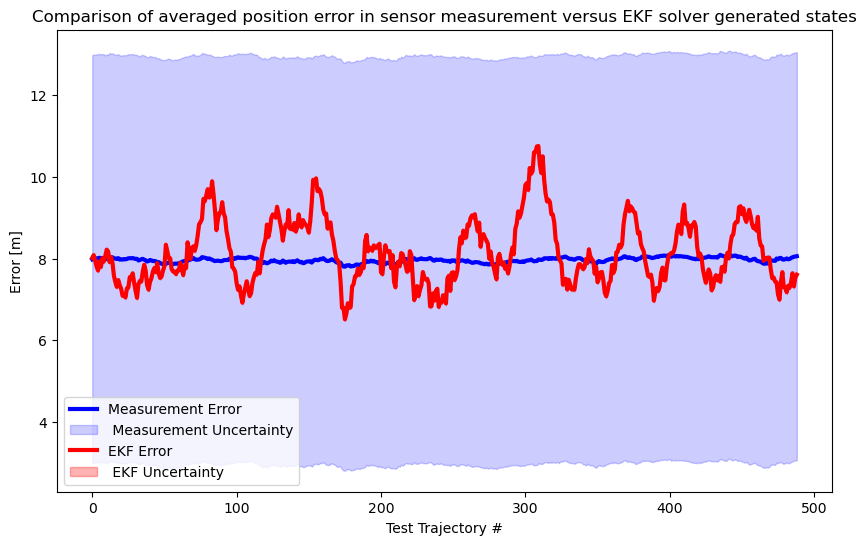

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_meas_err, label='Measurement Error', color='blue', linewidth=3)
plt.fill_between(range(len(smoothed_meas_err)), meas_lower_bound, meas_upper_bound, color='blue', alpha=0.2, label=' Measurement Uncertainty')

plt.plot(smoothed_ekf_err, label='EKF Error', color='red', linewidth=3)
plt.fill_between(range(len(smoothed_ekf_err)), ekf_lower_bound, ekf_upper_bound, color='red', alpha=0.3, label=' EKF Uncertainty')

plt.title('Comparison of averaged position error in sensor measurement versus EKF solver generated states')
plt.xlabel('Test Trajectory #')
plt.ylabel('Error [m]')
plt.legend()
plt.show()

In [29]:
print(np.mean(avg_ekf_err))
print(np.mean(adjusted_avg_ekf_uncertainty))

8.142382614120363
0.04156706619820895
